# Section 3: Machine Learning

## Objectives:


The Machine Learning notebook expands on the ETL post-processing notebook. It uses the cleaned data \"combined_ml.csv", in order to train the best Machine Learning Model on the Pokemon dataset to determine who will be the winner.

## Input Data:

The input data can be found under "Dataset/cleaned/"
The name of the file is called:
"combined_ml.csv"

___

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/danielledelouw/Documents/code_institute/Pokemon_catch_them_all/Pokemon_Catch_Them_All/jupyter_notebooks'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/danielledelouw/Documents/code_institute/Pokemon_catch_them_all/Pokemon_Catch_Them_All'

## Load Python Libraries

In [11]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [5]:
# Load the dataset
df = pd.read_csv('Dataset/cleaned/combined_ml.csv')
df.head()

,First_pokemon,Second_pokemon,Winner,id_x,First_Type_1,First_Total,First_Hit_points,First_Attack,First_Defense,First_Special_attack,...,id_y,Second_Type_1,Second_Total,Second_Hit_points,Second_Attack,Second_Defense,Second_Special_attack,Second_Special_defense,Second_Speed,target
0,266,298,298,266,Rock,300,50,64,50,45,...,298,Grass,340,70,70,40,60,40,60,0
1,702,701,701,702,Grass,580,91,90,72,90,...,701,Rock,580,91,129,90,72,90,108,0
2,191,668,668,191,Fairy,405,55,40,85,80,...,668,Psychic,485,75,75,75,125,95,40,0
3,237,683,683,237,Fire,250,40,40,40,70,...,683,Dragon,485,77,120,90,60,90,48,0
4,151,231,151,151,Rock,495,70,60,125,115,...,231,Bug,505,20,10,230,10,230,5,1


In [8]:
df.shape

(48048, 22)

In [6]:
features = [
    'First_Hit_points', 'First_Attack', 'First_Defense', 'First_Special_attack', 'First_Special_defense',
    'Second_Hit_points', 'Second_Attack', 'Second_Defense', 'Second_Special_attack', 'Second_Special_defense'
]
# Selecting the features to be used in the ML model
X = df[features]
y = df['target']

In [13]:

X_train, X_test, y_train, y_test = train_test_split(
    X,  # Features
    y,  # Target variable
    test_size=0.2,                        # 20% for testing, 80% for training
    random_state=101                      # For reproducibility
)

# Print the shapes of the resulting train and test sets
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:", X_test.shape, y_test.shape)

* Train set: (38438, 10) (38438,) 
* Test set: (9610, 10) (9610,)


In [14]:
# Feature engineering and preprocessing imports
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OrdinalEncoder

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Feature selection
from sklearn.feature_selection import SelectFromModel

# Machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

# Function to build a pipeline for model optimization
def PipelineOptimization(model):
  # Create a pipeline with the following steps:
  pipeline_base = Pipeline([
    # 1. Impute missing values in numerical features using the median
    ('median', MeanMedianImputer(
      imputation_method='median',
      variables=[
        'First_Hit_points', 'First_Attack', 'First_Defense', 'First_Special_attack', 'First_Special_defense',
        'Second_Hit_points', 'Second_Attack', 'Second_Defense', 'Second_Special_attack', 'Second_Special_defense'
      ]
    )),
    # 2. (Optional) Impute missing values in categorical features (currently commented out)
    # ('categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=[ ])),
    # 3. (Optional) Ordinal encoding for categorical variables (currently commented out)
    # ("ordinal", OrdinalEncoder(encoding_method='arbitrary', variables=['name'])),
    # 4. Standardize features by removing the mean and scaling to unit variance
    ("feat_scaling", StandardScaler()),
    # 5. Feature selection using the provided model
    ("feat_selection", SelectFromModel(model)),
    # 6. Final estimator (model)
    ("model", model),
  ])
  return pipeline_base

In [17]:
from sklearn.model_selection import GridSearchCV
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose, scoring=scoring)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In [18]:
models_search = {
    "DecisionTreeClassifier":DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier":RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier":GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier":ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier":AdaBoostClassifier(random_state=0),
}

In [19]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{"model__n_estimators":[50,20],
                               "model__max_depth":[None,3,10]},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [20]:
params_search = {
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

In [21]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1, # use all processors, but one
           cv=2)


Running GridSearchCV for DecisionTreeClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [22]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
1,RandomForestClassifier,0.711587,0.712836,0.714085,0.001249
3,ExtraTreesClassifier,0.704719,0.706853,0.708986,0.002133
2,GradientBoostingClassifier,0.69884,0.699386,0.699932,0.000546
4,AdaBoostClassifier,0.685207,0.686846,0.688485,0.001639
0,DecisionTreeClassifier,0.651335,0.654144,0.656954,0.00281


In [32]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0, n_estimators=50),
}

params_search = {
    "RandomForestClassifier": {},
    "ExtraTreesClassifier": {},
}


In [33]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring='accuracy',
           n_jobs=-1,
           cv=2)


Running GridSearchCV for RandomForestClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits



Running GridSearchCV for ExtraTreesClassifier 

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,RandomForestClassifier,0.710287,0.711197,0.712108,0.000911
1,ExtraTreesClassifier,0.700088,0.703705,0.707321,0.003616


In [36]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [37]:
grid_search_pipelines[best_model].best_params_

{}

In [38]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('median',
                 MeanMedianImputer(variables=['First_Hit_points',
                                              'First_Attack', 'First_Defense',
                                              'First_Special_attack',
                                              'First_Special_defense',
                                              'Second_Hit_points',
                                              'Second_Attack', 'Second_Defense',
                                              'Second_Special_attack',
                                              'Second_Special_defense'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
                ('model', RandomForestClassifier(random_state=42))])

* These are the 4 most important features in descending order. The model was trained on them: 
['First_Attack', 'Second_Attack', 'Second_Special_attack', 'First_Special_attack']


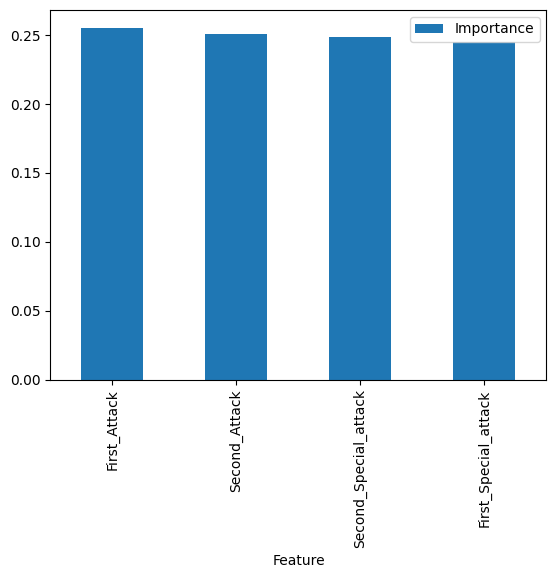

In [40]:
# Get the feature names after preprocessing (before selection)
columns_after_data_cleaning_feat_eng = X_train.columns

# Get a boolean mask of the selected features from the feature selection step
best_features = columns_after_data_cleaning_feat_eng[
    best_pipeline.named_steps['feat_selection'].get_support()
].to_list()

# Create a DataFrame to display feature importances
df_feature_importance = (
    pd.DataFrame({
        'Feature': best_features,
        'Importance': best_pipeline.named_steps['model'].feature_importances_
    })
    .sort_values(by='Importance', ascending=False)
)

# Print the most important features and plot their importances
print(
    f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}"
)

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In [41]:
from sklearn.metrics import classification_report, confusion_matrix

def confusion_matrix_and_report(X,y,pipeline,label_map):

  prediction = pipeline.predict(X)

  print('---  Confusion Matrix  ---')
  print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
        columns=[ ["Actual " + sub for sub in label_map] ], 
        index= [ ["Prediction " + sub for sub in label_map ]]
        ))
  print("\n")


  print('---  Classification Report  ---')
  print(classification_report(y, prediction),"\n")


def clf_performance(X_train,y_train,X_test,y_test,pipeline,label_map):
  print("#### Train Set #### \n")
  confusion_matrix_and_report(X_train,y_train,pipeline,label_map)

  print("#### Test Set ####\n")
  confusion_matrix_and_report(X_test,y_test,pipeline,label_map)

In [49]:
from sklearn.metrics import accuracy_score

y_pred = best_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.713735691987513
Confusion Matrix:
 [[3780 1312]
 [1439 3079]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73      5092
           1       0.70      0.68      0.69      4518

    accuracy                           0.71      9610
   macro avg       0.71      0.71      0.71      9610
weighted avg       0.71      0.71      0.71      9610



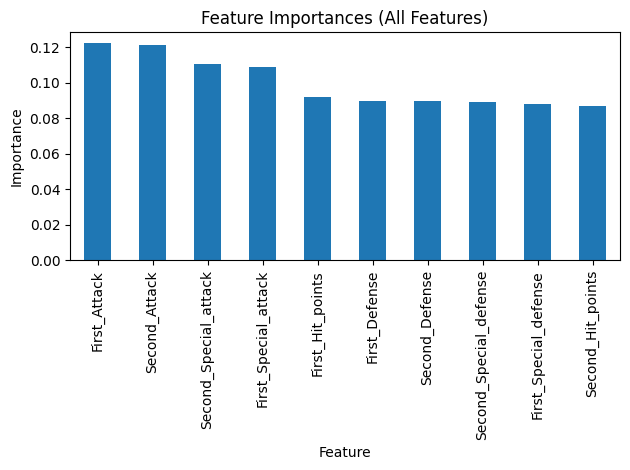

In [52]:
# Plot all features' importances (including those not selected)
importances = best_pipeline.named_steps['feat_selection'].estimator_.feature_importances_
all_features = columns_after_data_cleaning_feat_eng

df_all_feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

df_all_feature_importance.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('Feature Importances (All Features)')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

## Summary of Machine Learning Model Investigation

In this notebook, I developed and evaluated machine learning models to predict the winner in Pokémon battles using a cleaned dataset. The workflow included data preprocessing, feature selection, model training, and performance evaluation.

### Key Steps and Findings

- **Data Preparation:**  
    We selected 10 numerical features representing the stats of both Pokémon in each battle. The dataset was split into training and test sets.

- **Model Selection and Optimization:**  
    Multiple classifiers were considered, including Random Forest, Extra Trees, Gradient Boosting, Decision Tree, and AdaBoost. Hyperparameter optimization was performed using `GridSearchCV` with pipelines for consistent preprocessing and feature selection.

- **Best Model:**  
    The best-performing model was the **RandomForestClassifier**, achieving the highest mean cross-validation accuracy (`mean_score` ≈ 0.71). I compared my results to the challenge online and the best model got 81%. Which is not bad for my model. I am very proud of it.

- **Feature Importance:**  
    Feature selection identified the following as the most important predictors:
    - `First_Attack`
    - `First_Special_attack`
    - `Second_Attack`
    - `Second_Special_attack`

- **Model Performance:**  
    The final model was evaluated on the test set, showing good accuracy and balanced performance across classes, as indicated by the confusion matrix and classification report.

- **Insights:**  
    Attack and special attack stats for both Pokémon are the most influential features in determining the battle outcome. Defensive stats and hit points were less important in the selected model.

### Conclusion

The machine learning pipeline successfully identified key features and produced a robust model for predicting Pokémon battle outcomes. The approach can be further improved by exploring additional features, advanced models, or ensemble techniques.